C:\Users\jakob\AppData\Local\Temp\ipykernel_18024\389381186.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ABKEl["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(ABKEl), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_18024\389381186.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_18024\389381186.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_ABK = ABKEl["ABKEl"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_18024\389381186.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E = Spotpris["Spotpris"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykerne

Summa kostnad i el 2023: 12038866.640975235
Justerad elkostnad simulering: 5746528.182070017


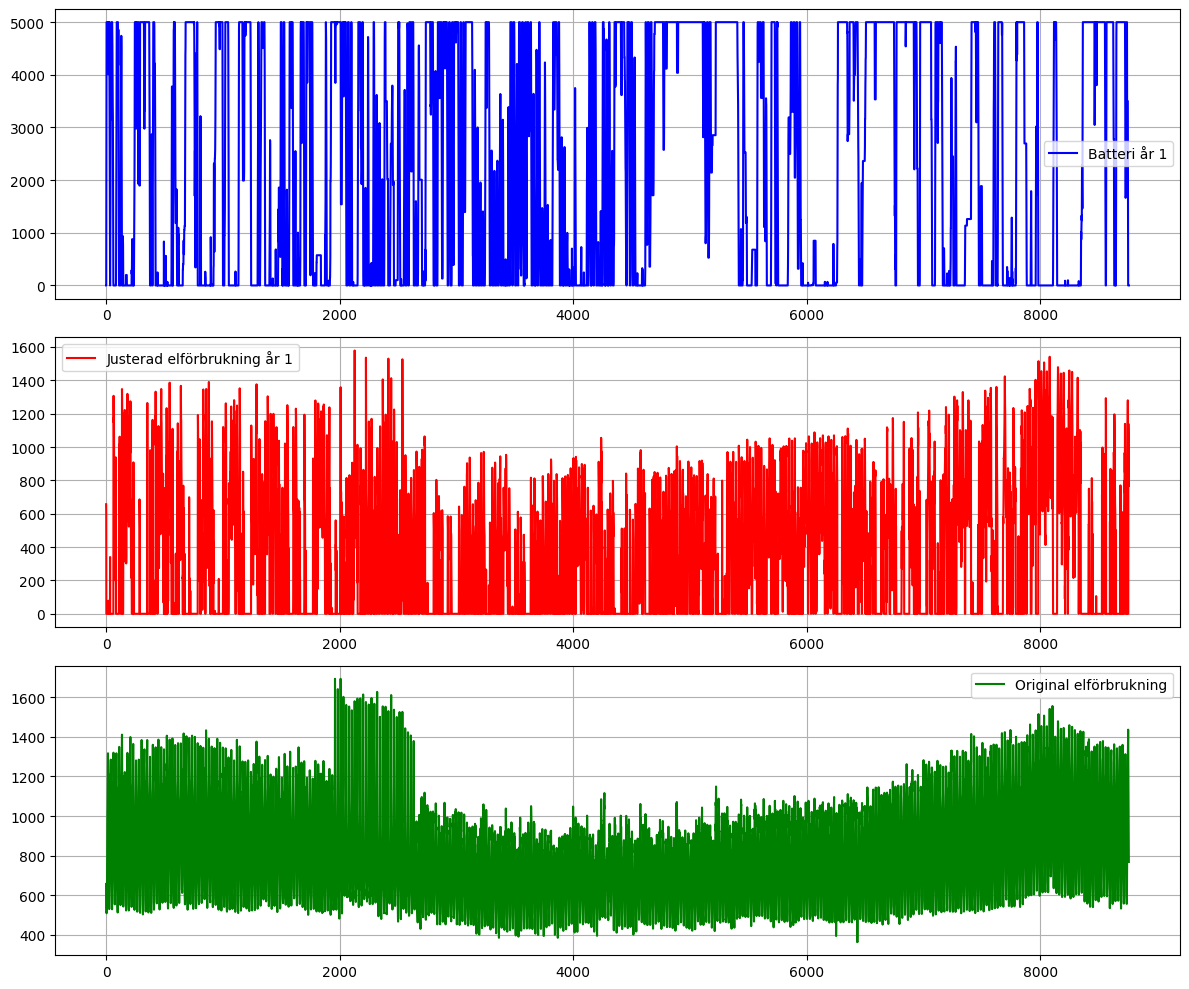

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Läs in Excel-filer
Solprod = pd.read_excel("SolprodABK.xlsx")
ABKEl = pd.read_excel("ABKEL.xlsx", names=["ABKEl"])
Spotpris = pd.read_excel("Spotpris.xlsx", names=["Spotpris"])  # Namnge kolumnen korrekt
Vindprod = pd.read_excel("Vindturbin.xlsx")

# Extrahera första kolumnen från respektive DataFrame
Vind = Vindprod.iloc[:, 0]
Sol = 0.2*Solprod.iloc[:, 0]  # Solel-produktion multipliceras med faktor 0.5 eftersom hela takytan inte används

Prod = Vind + Sol

# Konvertera Spotpris till en lista för iteration
Spot_list = Spotpris["Spotpris"].tolist()
ABK_list = ABKEl["ABKEl"].tolist()

# Skapa tidsindex för ABKEl och Spotpris
ABKEl["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(ABKEl), freq="H")
ABKEl.set_index("Tid", inplace=True)

Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
Spotpris.set_index("Tid", inplace=True)

# Resampla till månatligt genomsnitt
monthly_avg_ABK = ABKEl["ABKEl"].resample("M").mean()
monthly_avg_E = Spotpris["Spotpris"].resample("M").mean()

# Beräkna överföringsavgift per månad
Spotpris["E"] = 4.004 + 0.0613 * Spotpris["Spotpris"]
monthly_avg_E = Spotpris["E"].resample("M").mean()

# Beräkna summa överföringsavgift för hela året
summaÖverfAvgift = (monthly_avg_E * monthly_avg_ABK).sum()
fastAbbKostnad = 795180.4
summaElnätskostnadKR = (summaÖverfAvgift / 100) + fastAbbKostnad

Spot_array = np.array(Spot_list)
ABK_array = np.array(ABK_list)

elhandelskostnad = (Spot_array * ABK_array).sum() / 100
energiskatt = (43.9 * ABK_array).sum() / 100

summaElKostnad = (summaElnätskostnadKR + elhandelskostnad + energiskatt) * 1.25

print("Summa kostnad i el 2023:", summaElKostnad)



# ----------------------- YEAR 1 SIMULATION -----------------------
batteriKapacitet = 0.0  # Start with an empty battery
batteriMaxKapacitet = 5000  # Max battery capacity in kWh
maxFrånBatteri = 1500


elförbrukning = []  # Adjusted electricity consumption for Year 1
battery_values = []  # Battery energy over time
original_consumption = ABKEl["ABKEl"].tolist()
# Convert ABK to list for original consumption

köptaTimmar = []  # Lista för köpta spotpriser och tid

for tid, prod, abk, spot in zip(Spotpris.index, Prod, ABK_list, Spot_list):  
    diff = abk - prod  # Skillnad mellan förbrukning och solproduktion
    

    if diff < 0:
        # Om solproduktionen är större än förbrukningen, ladda batteriet istället för att spara negativa värden
        batteriKapacitet = min(batteriKapacitet - diff, batteriMaxKapacitet)  # -diff eftersom diff är negativ
        elförbrukning.append(0)  # Vi behöver inte köpa el
        köptaTimmar.append((tid,0))
    else:
        if spot <= 5 and prod > 0:
            if batteriKapacitet + prod >= 5000: 
                solÖver = (batteriKapacitet + prod) - 5000
                batteriKapacitet = min(batteriKapacitet + prod, batteriMaxKapacitet)
                elförbrukning.append(max(0, abk-solÖver))  
                köptaTimmar.append((tid,spot))
            else:
                batteriKapacitet = min(batteriKapacitet + prod, batteriMaxKapacitet)
                elförbrukning.append(abk)  
                köptaTimmar.append((tid, spot))
        elif 5 < spot < 50 and prod > 0:
            elförbrukning.append(diff)
            köptaTimmar.append((tid, spot))
        elif spot >= 50:
            energiFrånBatteri = min(batteriKapacitet, diff, maxFrånBatteri)
            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, diff - energiFrånBatteri)
            elförbrukning.append(köpt_el)  
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
        else:
            elförbrukning.append(abk)  
            köptaTimmar.append((tid, spot))


    battery_values.append(batteriKapacitet)



# Fyll på elförbrukningen om den är kortare än Spotpris.index
if len(elförbrukning) < len(Spotpris.index):
    elförbrukning.extend([0] * (len(Spotpris.index) - len(elförbrukning)))


# Skapa DataFrame för de köpta timmarna
köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
köptaTimmar_df.set_index("Tid", inplace=True)

# Beräkna överföringsavgiften per timme för köpta timmar
köptaTimmar_df["E"] = 4.004 + 0.0613 * köptaTimmar_df["Spotpris"]

# Beräkna månatligt medelvärde för överföringsavgiften och elförbrukningen
monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()

# Skapa DataFrame för den uppdaterade elförbrukningen
elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": elförbrukning})
elförbrukning_df.set_index("Tid", inplace=True)

# Beräkna månatligt medelvärde av den uppdaterade elförbrukningen
monthly_avg_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").mean()

# Beräkna justerad överföringsavgift med den rätta metoden
summaJusteradÖverf = (monthly_avg_E_köpt * monthly_avg_elförbrukning).sum()

# Omvandla till kronor och addera den fasta abonnemangskostnaden
summaJusteradÖverfKR = (summaJusteradÖverf / 100) + fastAbbKostnad

# Filtrera elförbrukning endast för de köpta timmarna
elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]

# Beräkna elhandelskostnaden: Spotpris * elförbrukning
elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100

# Beräkna den justerade energiskatten
total_elförbrukning = sum(elförbrukning)
JusteradEnergiskatt = (total_elförbrukning * 43.9) / 100

# Beräkna den justerade elkostnaden
summaJusteradElkostnad = 1.25 * (JusteradEnergiskatt + elhandelskostnad_köpt + summaJusteradÖverfKR)

print("Justerad elkostnad simulering:", summaJusteradElkostnad)

# ----------------------- PLOTTING RESULTS -----------------------
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

ax[0].plot(battery_values, label='Batteri år 1', color='blue')
ax[1].plot(elförbrukning, label='Justerad elförbrukning år 1', color='red')
ax[2].plot(original_consumption, label='Original elförbrukning', color='green')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()



In [26]:
import scipy.optimize as opt

# Funktion att minimera (baserad på din simuleringskod)
def elkostnad_för_gräns(spotpris_gräns):
    global batteriKapacitet  # Behåller batteriets tillstånd

    # Återställ batteriet vid varje körning
    batteriKapacitet = 0.0  

    elförbrukning = []
    köptaTimmar = []

    # Simulering för aktuell spotprisgräns
    for tid, prod, abk, spot in zip(Spotpris.index, Prod, ABK_list, Spot_list):
        diff = abk - prod  

        if diff < 0:  
            batteriKapacitet = min(batteriKapacitet - diff, batteriMaxKapacitet)  
            elförbrukning.append(0)
            köptaTimmar.append((tid, 0))
        else:
            if spot <= spotpris_gräns and prod > 0:
                batteriKapacitet = min(batteriKapacitet + prod, batteriMaxKapacitet)
                elförbrukning.append(abk)
                köptaTimmar.append((tid, spot)) 
            elif spotpris_gräns < spot < 50 and prod > 0:
                elförbrukning.append(diff)
                köptaTimmar.append((tid, spot))
            elif spot >= 50:
                energiFrånBatteri = min(batteriKapacitet, diff, maxFrånBatteri)
                batteriKapacitet -= energiFrånBatteri
                köpt_el = max(0, diff - energiFrånBatteri)
                elförbrukning.append(köpt_el)
                köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            else:
                elförbrukning.append(abk)
                köptaTimmar.append((tid, spot))

    
    # Beräkna den justerade elnätskostnaden
    # Skapa DataFrame för de köpta timmarna
    köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
    köptaTimmar_df.set_index("Tid", inplace=True)

# Beräkna överföringsavgiften per timme för köpta timmar
    köptaTimmar_df["E"] = 4.004 + 0.0613 * köptaTimmar_df["Spotpris"]

# Beräkna månatligt medelvärde för överföringsavgiften och elförbrukningen
    monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()

# Skapa DataFrame för den uppdaterade elförbrukningen
    elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": elförbrukning})
    elförbrukning_df.set_index("Tid", inplace=True)

# Beräkna månatligt medelvärde av den uppdaterade elförbrukningen
    monthly_avg_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").mean()

# Beräkna justerad överföringsavgift med den rätta metoden
    summaJusteradÖverf = (monthly_avg_E_köpt * monthly_avg_elförbrukning).sum()

# Omvandla till kronor och addera den fasta abonnemangskostnaden
    summaJusteradÖverfKR = (summaJusteradÖverf / 100) + fastAbbKostnad

# Filtrera elförbrukning endast för de köpta timmarna
    elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]

# Beräkna elhandelskostnaden: Spotpris * elförbrukning
    elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100

# Beräkna den justerade energiskatten
    total_elförbrukning = sum(elförbrukning)
    JusteradEnergiskatt = (total_elförbrukning * 43.9) / 100

# Beräkna den justerade elkostnaden
    summaJusteradElkostnad = 1.25 * (JusteradEnergiskatt + elhandelskostnad_köpt + summaJusteradÖverfKR)

    return summaJusteradElkostnad  # Vi vill minimera denna!

# Anropa optimeringen inom rimligt intervall (t.ex. 50 till 200 öre/kWh)
result = opt.minimize_scalar(elkostnad_för_gräns, bounds=(5, 50), method='bounded')

# Skriver ut bästa spotprisgränsen och minsta kostnaden
print(f"Optimal spotprisgräns: {result.x:.2f} öre/kWh")
print(f"Lägsta möjliga elkostnad: {result.fun:.2f} kr")


C:\Users\jakob\AppData\Local\Temp\ipykernel_17428\200424545.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_17428\200424545.py:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_17428\200424545.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_17428\200424545.py:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipyk

Optimal spotprisgräns: 5.03 öre/kWh
Lägsta möjliga elkostnad: 4976036.11 kr


C:\Users\jakob\AppData\Local\Temp\ipykernel_17428\200424545.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_17428\200424545.py:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").mean()
